In [1]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.feature import corner_harris, corner_peaks
import svgwrite
import matplotlib.pyplot as plt
from skimage import io

In [2]:
# Function to display images
def display_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Step 1: Make shapes hollow
def make_shapes_hollow(image, line_thickness=1):
    print("Step 1: Making filled shapes hollow...")
    
    # Thresholding to binary (0 or 255)
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours from the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a blank canvas to draw the hollow outlines
    hollow_image = np.zeros_like(binary_image)
    
    # Draw only the contours on the hollow_image (ignoring the filled regions)
    cv2.drawContours(hollow_image, contours, -1, (255), 1)  # Thickness of 1 for hollow outline
    
    # If line_thickness is greater than 1, apply dilation to thicken the lines
    if line_thickness > 1:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (line_thickness, line_thickness))
        hollow_image = cv2.dilate(hollow_image, kernel, iterations=1)
    
    # Show the result of Step 1
    display_image(hollow_image, "Hollow and Thickened Shapes")
    
    return hollow_image

# Step 2: Skeletonize the hollowed image
def skeletonize_image(hollow_image):
    print("Step 2: Skeletonizing the hollow shapes...")
    
    # Convert the hollow image to a binary format (0 and 1) for skeletonization
    binary_hollow_image = hollow_image > 0
    
    # Apply skeletonization
    skeleton = skeletonize(binary_hollow_image)
    
    # Convert back to 255 scale for display purposes
    skeleton_image = (skeleton * 255).astype(np.uint8)
    
    # Show the skeletonized result
    display_image(skeleton_image, "Skeletonized Image")
    
    cv2.imwrite('TEST.png', skeleton_image)
    
    return skeleton_image

# Main function
def main(image_path):
    # Load the input image (assumed to be grayscale or already binary)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Step 1: Make shapes hollow
    hollow_image = make_shapes_hollow(image, line_thickness=25)
    
    # Step 2: Skeletonize the hollow shapes
    skeleton_image = skeletonize_image(hollow_image)

Step 1: Making filled shapes hollow...


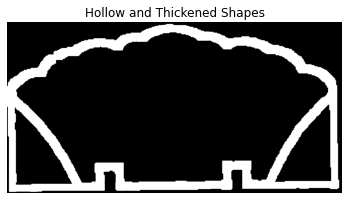

Step 2: Skeletonizing the hollow shapes...


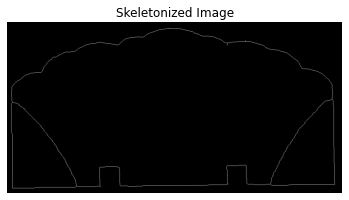

In [4]:
main('ppp.png')

In [82]:
# Utility function to display images in Jupyter
def display_image(image, title="Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# Step 1: Convert filled shapes to hollow by detecting the contours
def make_shapes_hollow(image, line_thickness=1):
    print("Step 1: Making filled shapes hollow...")
    
    # Thresholding to binary (0 or 255)
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours from the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a blank canvas to draw the hollow outlines
    hollow_image = np.zeros_like(binary_image)
    
    # Draw only the contours on the hollow_image (ignoring the filled regions)
    cv2.drawContours(hollow_image, contours, -1, (255), 1)  # Thickness of 1 for hollow outline
    
    # If line_thickness is greater than 1, apply dilation to thicken the lines
    if line_thickness > 1:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (line_thickness, line_thickness))
        hollow_image = cv2.dilate(hollow_image, kernel, iterations=1)
    
    # Show the result of Step 1
    display_image(hollow_image, "Hollow and Thickened Shapes")
    
    return hollow_image

# Step 2: Skeletonize the hollow image using scikit-image
def skeletonize_image(hollow_image):
    print("Step 2: Extracting centerline (skeletonizing) the image...")
    
    # Convert the hollow image to binary (0-1 range) for skeletonization
    binary_hollow = hollow_image // 255
    
    # Skeletonize the binary image using scikit-image's skeletonize function
    skeleton = skeletonize(binary_hollow).astype(np.uint8) * 255
    
    # Show the result of Step 2
    display_image(skeleton, "Skeletonized Image (Centerlines)")
    
    return skeleton

# Step 3: Detect and handle forks in skeletonized lines
def detect_forks_and_merge_pipes(skeleton_image):
    print("Step 3: Detecting forks and merging pipes...")
    
    # Find fork points by checking the number of neighbors each pixel has
    kernel = np.ones((3, 3), np.uint8)
    neighbors_count = cv2.filter2D(skeleton_image, -1, kernel)
    
    # Fork points are where more than 2 neighbors exist
    fork_points = np.where(neighbors_count > 3, 255, 0).astype(np.uint8)
    
    # Create an empty image to visualize forks and lines merging
    fork_image = np.zeros_like(skeleton_image)
    fork_image[fork_points == 255] = 255
    
    # Show the fork points
    display_image(fork_image, "Fork Points")
    
    return skeleton_image, fork_points

# Step 4: Trace the outline of the skeleton
def find_contours(skeleton_image):
    print("Step 4: Finding contours in the skeletonized image...")
    
    # Find contours from the skeletonized image
    contours, _ = cv2.findContours(skeleton_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Approximate each contour to a polygon
    polygons = []
    for contour in contours:
        epsilon = 0.01 * cv2.arcLength(contour, True)  # Adjust epsilon for smoothness
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        polygons.append(polygon)
    
    # Create an empty image to draw contours
    contour_image = np.zeros_like(skeleton_image)
    cv2.drawContours(contour_image, contours, -1, (255), 1)
    
    # Show the result of Step 4
    display_image(contour_image, "Contour Image")
    
    return polygons

# Step 5: Classify edges as straight or curved
def classify_edges(contours, skeleton_image):
    print("Step 5: Classifying edges as straight or curved...")
    
    edges = []
    for contour in contours:
        for i in range(len(contour) - 1):
            p1 = contour[i][0]
            p2 = contour[i + 1][0]
            dist = np.linalg.norm(p2 - p1)
            if dist > 5:  # Edge length threshold for "straight"
                edges.append((tuple(map(int, p1)), tuple(map(int, p2))))  # Ensure coordinates are integers
    
    # Display the edges on an empty image
    edge_image = np.zeros((skeleton_image.shape[0], skeleton_image.shape[1], 3), dtype=np.uint8)
    for edge in edges:
        start, end = edge
        cv2.line(edge_image, start, end, (0, 255, 0), 1)
    
    # Show the result of Step 5
    display_image(edge_image, "Edges Classified")
    
    return edges

# Step 6: Export to SVG for CorelDRAW
def export_to_svg(edges, output_file='output.svg'):
    print("Step 6: Exporting to SVG...")
    
    dwg = svgwrite.Drawing(output_file, profile='tiny')
    
    for edge in edges:
        start, end = edge
        dwg.add(dwg.line(start=start, end=end, stroke=svgwrite.rgb(0, 0, 0, '%')))
    
    dwg.save()
    print(f"SVG file saved to {output_file}")

# Main function to process the image
def process_image(image_path, output_file='output.svg'):
    # Step 1: Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Step 1: Make the shapes hollow
    hollow_image = make_shapes_hollow(image, line_thickness=15)
    
    # Step 2: Skeletonize the hollow image (centerline extraction)
    skeleton = skeletonize_image(hollow_image)
    
#     # Step 3: Detect forks and handle pipe merging
#     skeleton_with_forks, fork_points = detect_forks_and_merge_pipes(skeleton)
    
#     # Step 4: Find contours in the skeletonized image
#     contours = find_contours(skeleton_with_forks)
    
#     # Step 5: Classify edges
#     edges = classify_edges(contours, skeleton)
    
    # Step 6: Export the outlines to SVG
    export_to_svg(skeleton, output_file)

Step 1: Making filled shapes hollow...


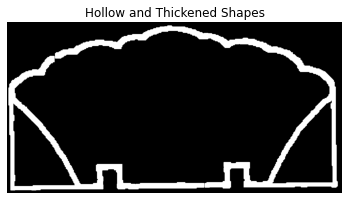

Step 2: Extracting centerline (skeletonizing) the image...


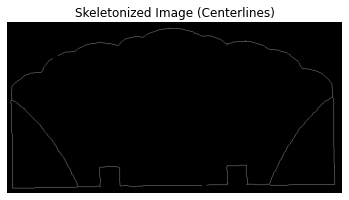

Step 6: Exporting to SVG...


ValueError: too many values to unpack (expected 2)

In [83]:
process_image('ppp.png')